# Topic Modeling with BERT

In [22]:
import numpy as np
import pandas as pd

import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm


def c_tf_idf(documents, m, ngram_range=(1, 1)):
    """ Calculate a class-based TF-IDF where m is the number of total documents. """
    # count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    # t = count.transform(documents)
    # t = np.array(t.todense()).T
    # w = t.sum(axis=0)
    # tf = np.divide(t, w)
    # sum_tij = np.array(t.sum(axis=1)).T
    # idf = np.log(np.divide(m, sum_tij)).reshape(-1, 1)
    # tf_idf = np.multiply(tf, idf)

    # Cleaner version
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
  words = count.get_feature_names()
  labels = list(docs_per_topic.labels)
  tf_idf_transposed = tf_idf.T
  indices = tf_idf_transposed.argsort()[:, -n:]
  top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}

  return top_n_words

## Load data
For this example, let's use the famous 20Newsgroups dataset which contains roughly 18000 newsgroups posts on 20 topics.

In [120]:
data = fetch_20newsgroups(subset='all')['data']
# data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))["data"]

## Create embeddings
The very first step is converting the documents to numerical data. There are many methods that can be applied, but since we are modeling topics with **BERT** that is what we are going to be using.

There are many pre-trained models that you can use for a large amount of languages [here](https://www.sbert.net/docs/pretrained_models.html). Simply plug-in the name instead of *distilbert-base-nli-mean-tokens*. 

In [121]:
%%time
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)


CPU times: user 5min 16s, sys: 24 s, total: 5min 40s
Wall time: 5min 39s


## Reduce dimensionality
We use **UMAP** to reduce the dimensionality of the embeddings created above. It is important that we keep a little bit of dimensionality as that allows the reduced embeddings to contain more structure to improve clustering at a later stage. 

You can play around with the **number of components** (dimensionality to reduce to) and the **number of neighbors** (the nearby points to look at). 

In [122]:
%%time
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine').fit_transform(embeddings)

CPU times: user 52.2 s, sys: 1.2 s, total: 53.4 s
Wall time: 36.5 s


## Cluster documents
Since **UMAP** keeps some of the original high-embedded structure, it makes sense to use **HDBSCAN** to find highly-densed clusters. The metric is euclidean since it does not suffer from high-dimensionality and the **minimum cluster size** allows you to decrease the number of topics found and increase the topic sizes. 

In [123]:
%%time
cluster = hdbscan.HDBSCAN(min_cluster_size=30,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

CPU times: user 555 ms, sys: 605 ms, total: 1.16 s
Wall time: 3.85 s


## Visualize Clusters
We can visualize the resulting cluster by embedding the data into **2d-space** using **UMAP** and using matplotlib to color the clusters. Some clusters are difficult to spot as there may be > 50 topics generated. 

In [143]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])

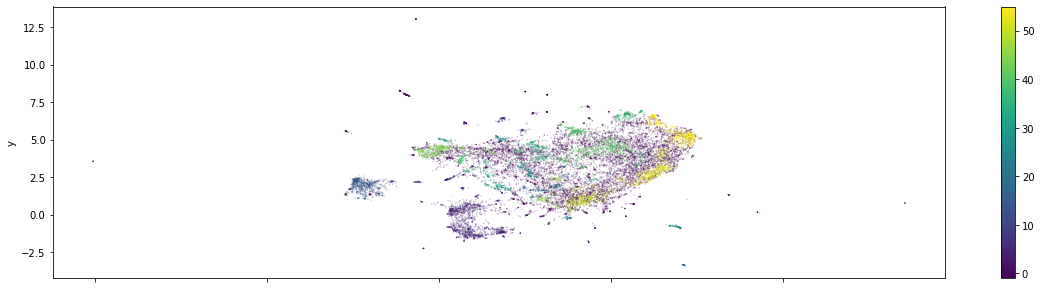

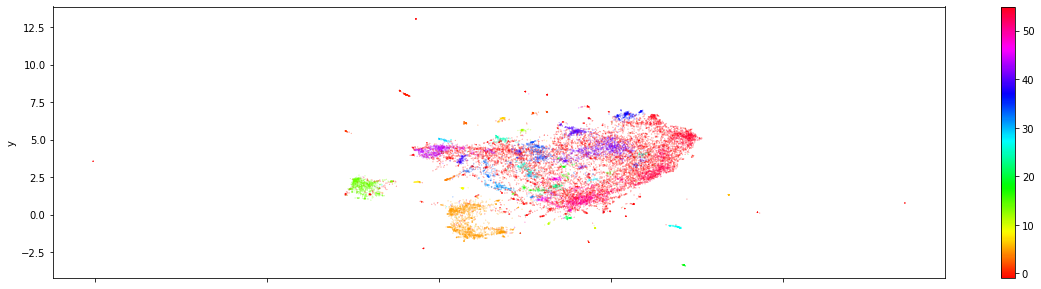

In [144]:
result.plot.scatter(x="x",  y="y", s=0.02, c=cluster.labels_, colormap='viridis', figsize=(20, 5))
result.plot.scatter(x="x",  y="y", s=0.02, c=cluster.labels_, colormap='hsv', figsize=(20, 5))

## Prepare results
For easier selection, we put the results in a pandas dataframe. Then, *docs_per_label* is created in which all documents within a single cluster are joined. 

In [110]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['labels'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_label = docs_df.groupby(['labels'], as_index = False).agg({'Doc': ' '.join})

## Calculate word importance per topic
Calculate the importance of words  in a topic compared to all other topics by considering all documents in a topic to be a single document instead before applying **TF-IDF**. Then, we simply extract the words with the highest values in each cluster as a representative of a topic. 

In [111]:
m = len(data)
tf_idf, count = c_tf_idf(docs_per_label.Doc.values, m)

In [112]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_label, n=20)
count_df = docs_df.groupby(['labels']).count().sort_values("Doc", ascending=False).reset_index(); count_df.head(10)

,labels,Doc,Doc_ID
0,14,7827,7827
1,-1,4201,4201
2,1,1664,1664
3,18,1637,1637
4,0,507,507
5,13,505,505
6,10,431,431
7,21,261,261
8,29,226,226
9,12,175,175


In [119]:
top_n_words[28]

[('defamation', 0.02908344422950948),
 ('police', 0.028001271642840716),
 ('batf', 0.023299537455730303),
 ('league', 0.020924238771199068),
 ('warrant', 0.02031930781855413),
 ('koresh', 0.02028010143541676),
 ('cranston', 0.020212395133274833),
 ('francisco', 0.019626192869588617),
 ('anti', 0.019334165827834853),
 ('san', 0.016765724894087508),
 ('_____', 0.01667024972520855),
 ('bullock', 0.016306883206267574),
 ('teenager', 0.016035968017223578),
 ('enforcement', 0.01578990964071283),
 ('law', 0.01505522696054074),
 ('adl', 0.014722908246629576),
 ('released', 0.014460622997840851),
 ('key', 0.014232107871614552),
 ('agents', 0.013903587113799066),
 ('raid', 0.013235358767782018)]

## Topic Reduction

In [ ]:
for i in tqdm(range(20)):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    count_df = docs_df.groupby(['labels']).count().sort_values("Doc", ascending=False).reset_index()
    label_to_merge = count_df.iloc[-1].labels
    label_to_merge_into = np.argmax(similarities[label_to_merge+1]) - 1

    print(np.max(similarities[label_to_merge+1]))

    # Adjust labels
    docs_df.loc[docs_df.labels == label_to_merge, "labels"] = label_to_merge_into
    docs_df = docs_df.sort_values("labels")
    labels = docs_df.labels.unique()
    new_labels = [i-1 for i in range(len(labels))]
    map_labels = {label: new_label for label, new_label in zip(labels, new_labels)}
    docs_df.labels = docs_df.labels.map(map_labels)
    docs_per_label = docs_df.groupby(['labels'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_label.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_label, n=20)
    count_df = docs_df.groupby(['labels']).count().sort_values("Doc", ascending=False).reset_index()

  0%|          | 0/20 [00:00<?, ?it/s]

0.27330793275738335


  5%|▌         | 1/20 [00:09<03:06,  9.81s/it]

0.13956580113493186


 10%|█         | 2/20 [00:19<02:55,  9.75s/it]

0.31778666186006993


 15%|█▌        | 3/20 [00:28<02:44,  9.67s/it]

0.16763846770322935


 20%|██        | 4/20 [00:38<02:33,  9.58s/it]

0.3653161648268821


 25%|██▌       | 5/20 [00:47<02:22,  9.52s/it]

0.27181788270977864


 30%|███       | 6/20 [00:56<02:12,  9.47s/it]

0.224052470310666


 35%|███▌      | 7/20 [01:06<02:02,  9.42s/it]

0.31545640850543333


 40%|████      | 8/20 [01:15<01:52,  9.40s/it]

0.20566824984294865


 45%|████▌     | 9/20 [01:24<01:42,  9.36s/it]

0.20209132888216574


 50%|█████     | 10/20 [01:34<01:33,  9.33s/it]

0.3553036243202598


 55%|█████▌    | 11/20 [01:43<01:23,  9.32s/it]

0.19402125671942483


 60%|██████    | 12/20 [01:52<01:14,  9.29s/it]

0.5956790068806729


 65%|██████▌   | 13/20 [02:02<01:05,  9.32s/it]

0.289831672368263


 70%|███████   | 14/20 [02:11<00:55,  9.29s/it]

0.3298583259578729


 75%|███████▌  | 15/20 [02:20<00:46,  9.27s/it]

0.37119975869970834


 80%|████████  | 16/20 [02:29<00:37,  9.27s/it]

0.27587741102048857


 85%|████████▌ | 17/20 [02:39<00:27,  9.26s/it]

0.24960535765876316


 90%|█████████ | 18/20 [02:48<00:18,  9.25s/it]

0.607756239207291


 95%|█████████▌| 19/20 [02:57<00:09,  9.26s/it]

0.2620931937008584


100%|██████████| 20/20 [03:06<00:00,  9.34s/it]


In [ ]:
result["new_label"] = docs_df.sort_values("Doc_ID").labels

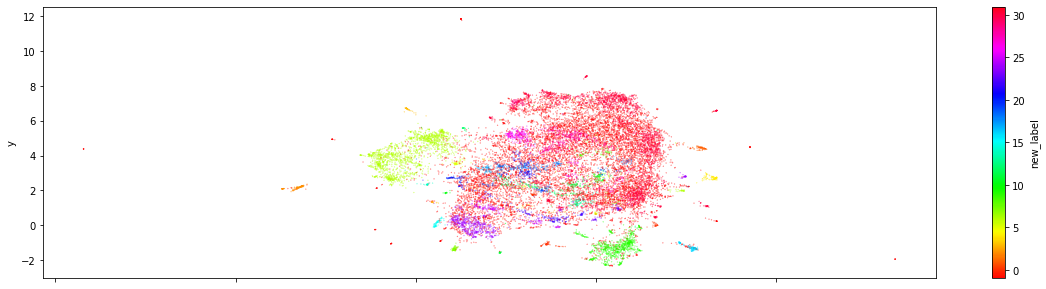

In [ ]:
result.plot.scatter(x="x",  y="y", s=0.04, c="new_label", colormap='hsv', figsize=(20, 5))

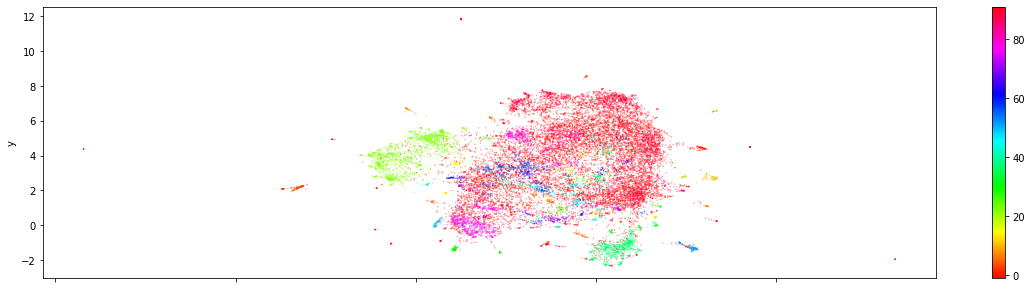

In [ ]:
result.plot.scatter(x="x",  y="y", s=0.04, c=cluster.labels_, colormap='hsv', figsize=(20, 5))

In [ ]:
len(result.new_label.unique())

33

In [ ]:
len(set(cluster.labels_))

93

In [ ]:
count_df.head(10)

,labels,Doc,Doc_ID
0,-1,9323,9323
1,30,2627,2627
2,6,1737,1737
3,9,841,841
4,24,632,632
5,28,460,460
6,18,316,316
7,26,315,315
8,21,190,190
9,25,185,185


In [ ]:
top_n_words[26]

[('92', 0.013919726390617976),
 ('doctor', 0.011776185126014159),
 ('pitt', 0.011610902233728333),
 ('pain', 0.011446508256140839),
 ('geb', 0.011430837326534363),
 ('vitamin', 0.010904287980114261),
 ('gordon', 0.010661971981814894),
 ('banks', 0.010630691803726852),
 ('medical', 0.008563001601624213),
 ('treatment', 0.0074816286372531285),
 ('hiv', 0.0071956823440103),
 ('food', 0.007006609811663472),
 ('disease', 0.0068972075094014176),
 ('kidney', 0.0067781965829760435),
 ('infection', 0.00675402213301823),
 ('patients', 0.006623009501319811),
 ('diet', 0.006591056057463909),
 ('pms', 0.0063948151826804765),
 ('12', 0.006316740470979196),
 ('symptoms', 0.006219489236931822)]